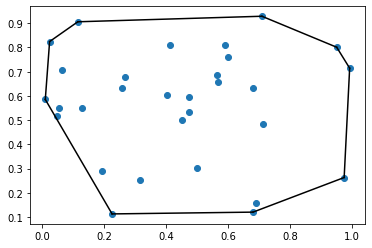

In [1]:
import numpy as np
import scipy as sp
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt



rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')